# Datos desbalanceados

## 1. Análisis exploratorio

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from pylab import rcParams
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier
from collections import Counter
import os

In [4]:
data_rute = os.path.join('Datasets', 'creditcard.csv')
df = pd.read_csv(data_rute)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
print(df.shape)
print(df.value_counts(df['Class'], sort=True))

(284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


C:\Users\pepel\AppData\Local\Temp\ipykernel_5956\979456514.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort=True)


Text(0, 0.5, 'Number of observations')

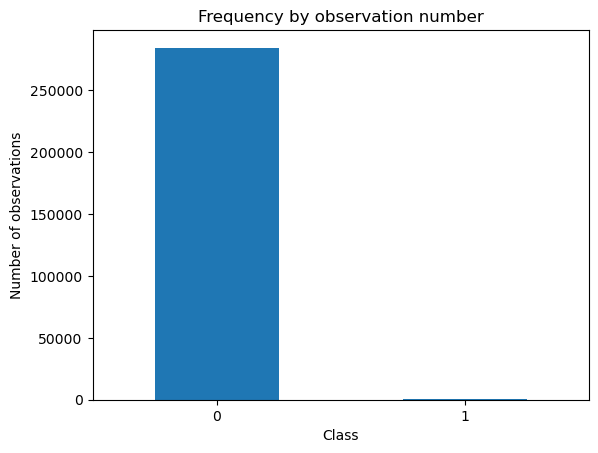

In [7]:
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.xticks(range(2))
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of observations")

## 2. Probando el modelo sin estrategias

c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\sklearn\utils\optimize.py:44: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


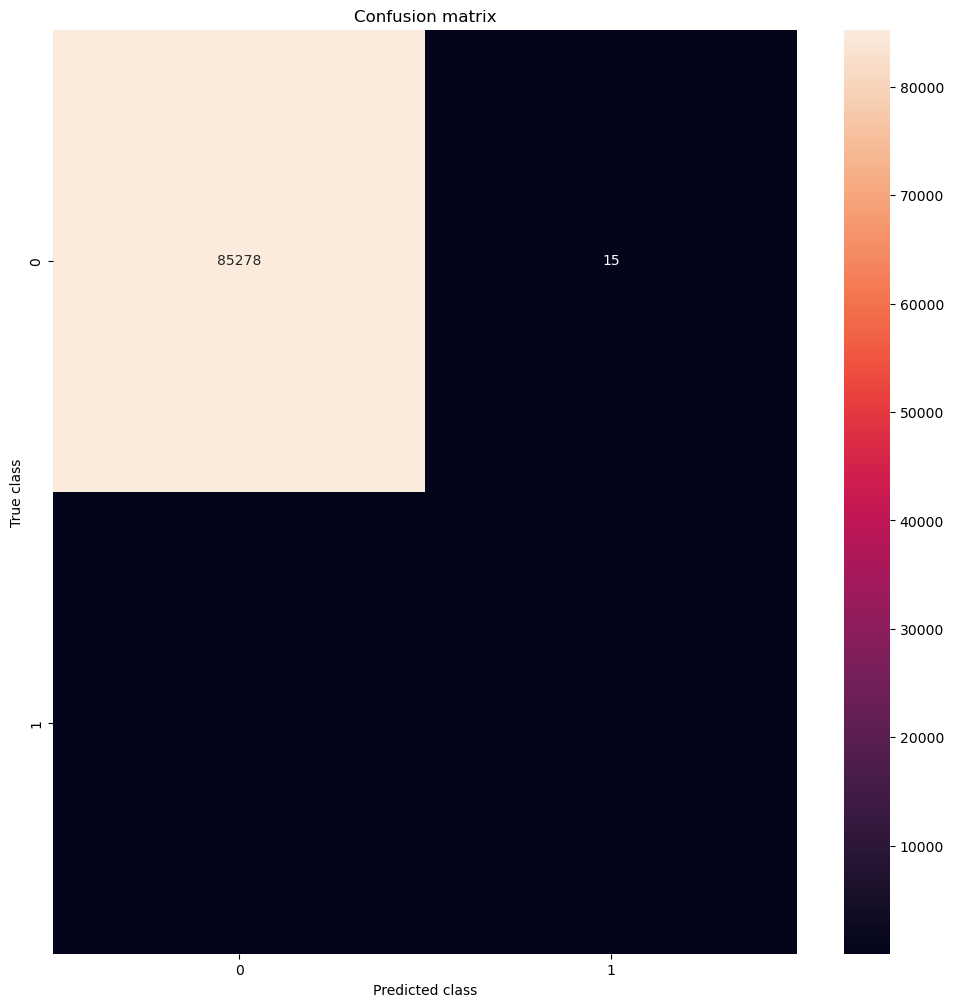

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85293
           1       0.87      0.68      0.76       150

    accuracy                           1.00     85443
   macro avg       0.94      0.84      0.88     85443
weighted avg       1.00      1.00      1.00     85443



In [8]:
# Definimos nuestras etiquetas y features
y = df['Class']
X = df.drop('Class', axis=1)

# Dividimos en sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

# Creamos una función que crea el modelo que usaremos cada vez
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(
        C=1.0,
        penalty='l2',
        random_state=1,
        solver='newton-cg'
    )
    clf_base.fit(X_train, y_train)
    return clf_base

# Ejecutamos el modelo
model = run_model(X_train, X_test, y_train, y_test)

# Definimos una función para mostrar los resultados
def mostrar_resultados(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title("Confusion matrix")
    plt.ylabel("True class")
    plt.xlabel("Predicted class")
    plt.show()
    print(classification_report(y_test, y_pred))

y_pred = model.predict(X_test)
mostrar_resultados(y_test, y_pred)

## 3. Estrategia: Penalización para compensar

c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


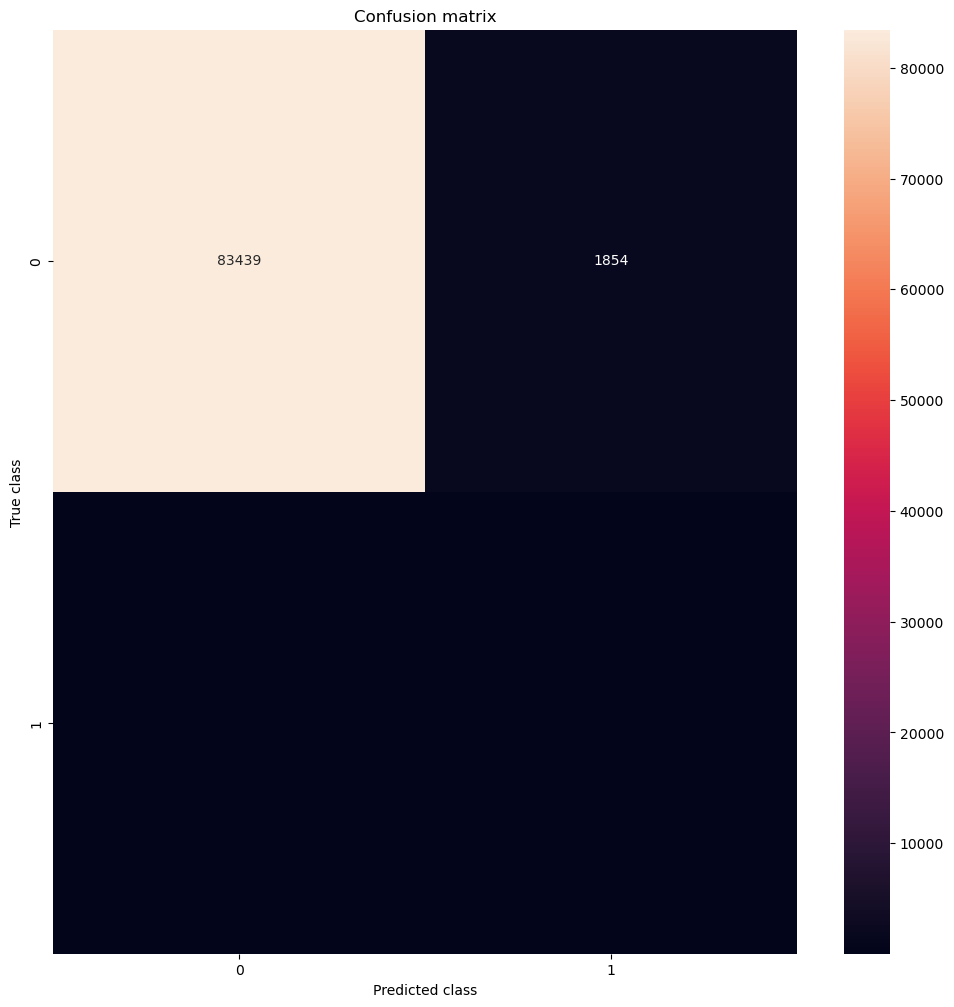

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85293
           1       0.07      0.88      0.12       150

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [9]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(
        C=1.0,
        penalty='l2',
        random_state=1,
        solver='newton-cg',
        class_weight='balanced'
    )
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)
y_pred = model.predict(X_test)
mostrar_resultados(y_test, y_pred)

## 4. Estrategia: Subsampling en la clase mayoritaria

Distribution before resampling Counter({0: 199022, 1: 342})
Distribution after resampling Counter({0: 342, 1: 342})


c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\sklearn\utils\optimize.py:44: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


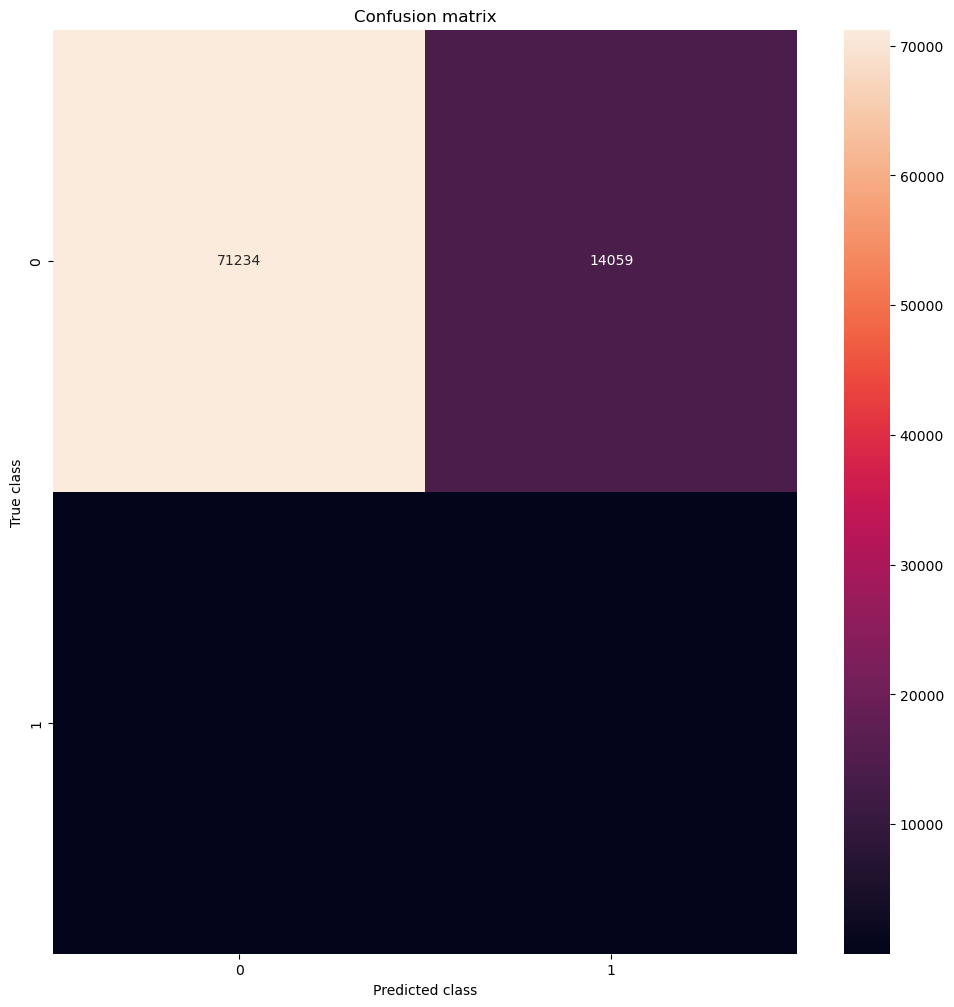

              precision    recall  f1-score   support

           0       1.00      0.84      0.91     85293
           1       0.01      0.93      0.02       150

    accuracy                           0.84     85443
   macro avg       0.50      0.88      0.46     85443
weighted avg       1.00      0.84      0.91     85443



In [14]:
us = NearMiss(n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, y_train)

print("Distribution before resampling {}".format(Counter(y_train)))
print("Distribution after resampling {}".format(Counter(y_train_res)))

model = run_model(X_train_res, X_test, y_train_res, y_test)
y_pred = model.predict(X_test)
mostrar_resultados(y_test, y_pred)

## 5. Estrategia: Oversampling de la clase minoritaria

Distribution before resampling Counter({0: 199022, 1: 342})
Distribution labels after resampling Counter({0: 199022, 1: 199022})


c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


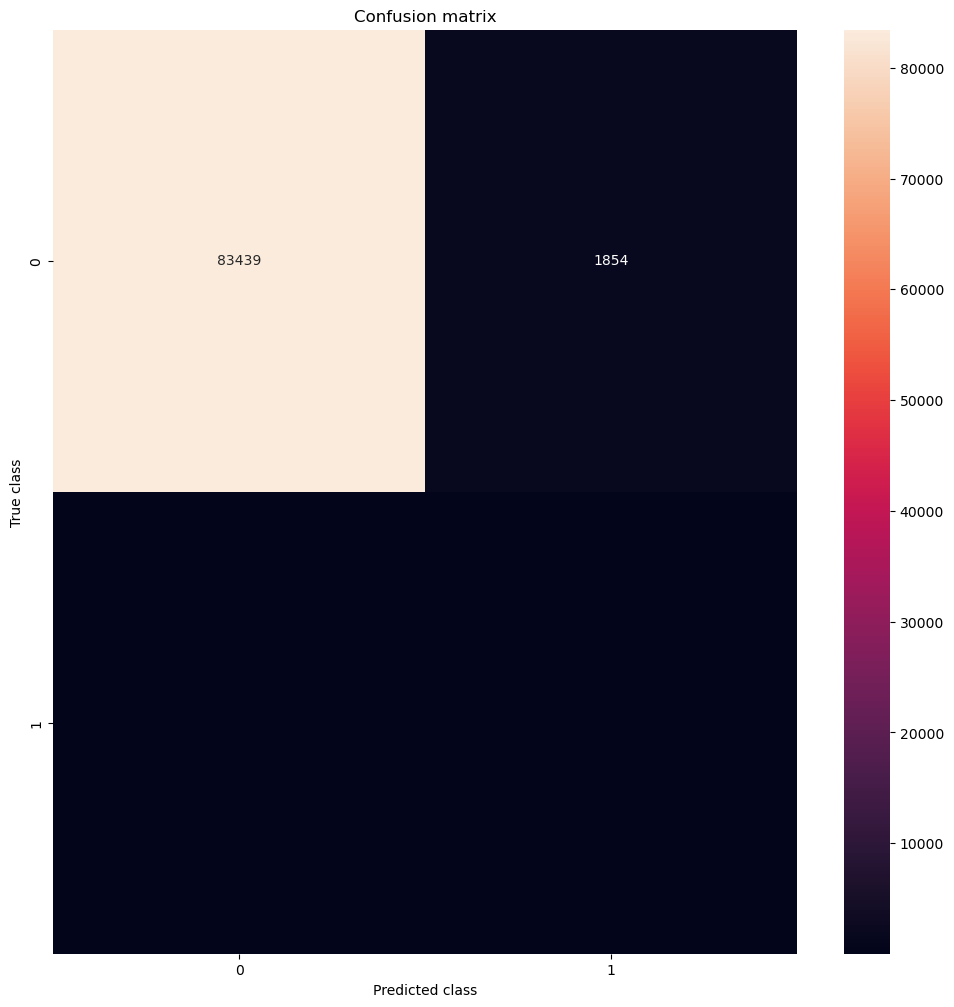

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85293
           1       0.07      0.88      0.12       150

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [16]:
os = RandomOverSampler()
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

print("Distribution before resampling {}".format(Counter(y_train)))
print("Distribution labels after resampling {}".format(Counter(y_train_res)))

model = run_model(X_train_res, X_test, y_train_res, y_test)
y_pred = model.predict(X_test)
mostrar_resultados(y_test, y_pred)

## 6. Estrategia: Combinamos resampling con Smote-Tomek

Distribution before resampling Counter({0: 199022, 1: 342})
Distribution after resampling Counter({0: 198499, 1: 198499})


c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\sklearn\utils\optimize.py:44: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


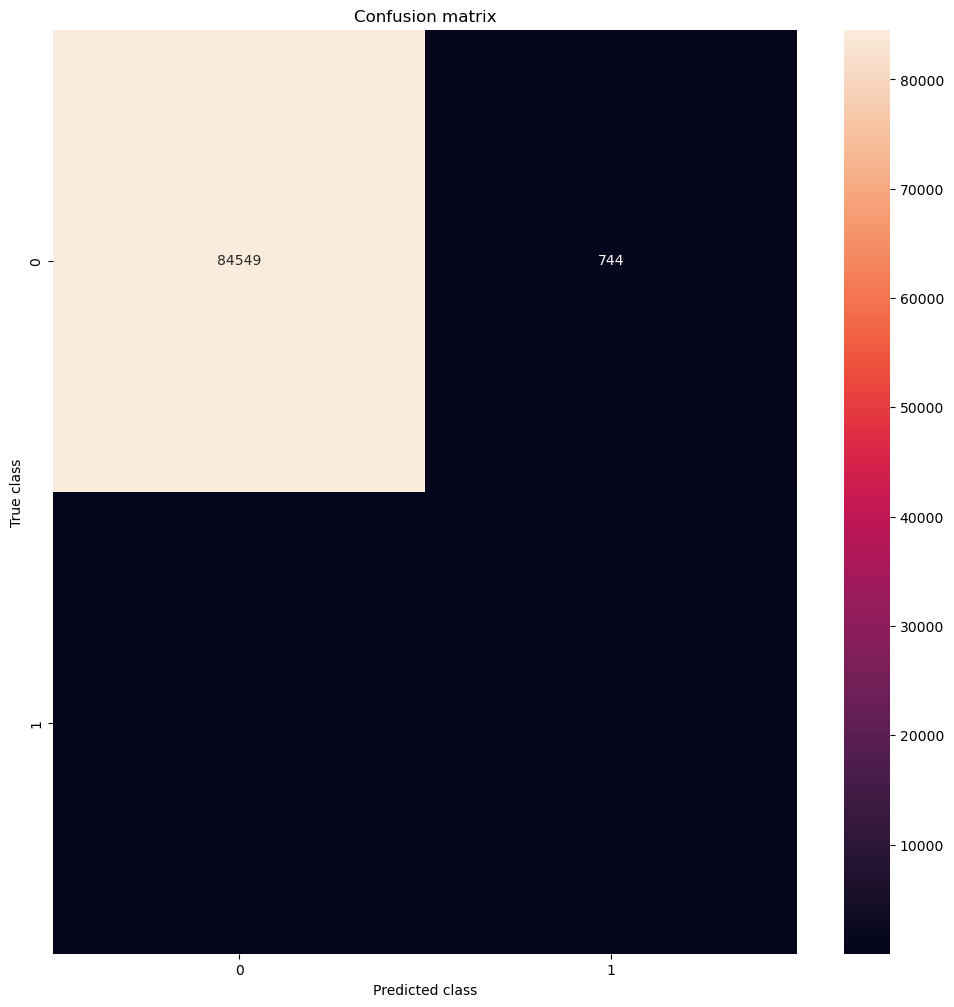

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85293
           1       0.15      0.89      0.26       150

    accuracy                           0.99     85443
   macro avg       0.58      0.94      0.63     85443
weighted avg       1.00      0.99      0.99     85443



In [17]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(X_train, y_train)

print("Distribution before resampling {}".format(Counter(y_train)))
print("Distribution after resampling {}".format(Counter(y_train_res)))

model = run_model(X_train_res, X_test, y_train_res, y_test)
y_pred = model.predict(X_test)
mostrar_resultados(y_test, y_pred)

## 7. Estrategia: Ensamble de modelos con balanceo

c:\Users\pepel\.conda\envs\PySpace310\lib\site-packages\imblearn\ensemble\_bagging.py:362: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


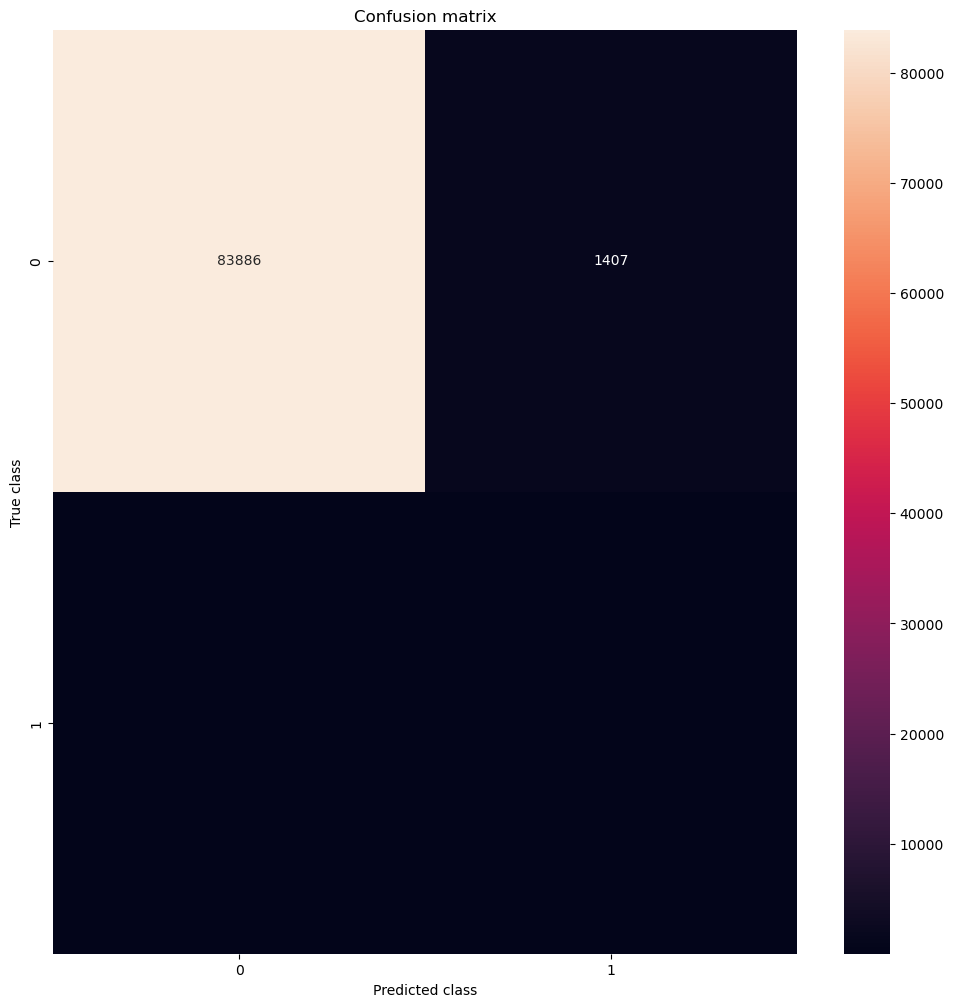

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85293
           1       0.08      0.86      0.15       150

    accuracy                           0.98     85443
   macro avg       0.54      0.92      0.57     85443
weighted avg       1.00      0.98      0.99     85443



In [18]:
bbc = BalancedBaggingClassifier(
    base_estimator=DecisionTreeClassifier(),
    sampling_strategy='auto',
    replacement=False,
    random_state=0
)

# Entrenamiento del clasificador
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
mostrar_resultados(y_test, y_pred)